In [98]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

### Libs

In [124]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# plot the regression fit for comparison
def plot_fit(feature, target, coefficients, intercept):
    plt.scatter(feature, target,  color='blue')
    xi = np.arange(0.0, 1.0, 0.1)
    line = coefficients * xi + [[intercept]]
    plt.plot(xi, line[0])
    return plt

### Data

In [100]:
# we fake some events with good correlation
N_EVENTS = 100
feature = np.random.rand(N_EVENTS)
target = feature + np.random.rand(N_EVENTS)*0.2
df = pd.DataFrame(data = zip(feature, target), columns=['feature', 'target'])
df.head(3)

,feature,target
0,0.374540,0.380826
1,0.950714,1.077996
2,0.731994,0.794865


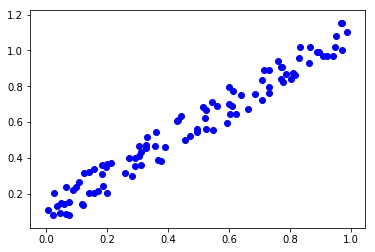

In [101]:
plt.scatter(feature, target, color='blue')
plt.show()

### Prepare Data for Tensor Flow

In [102]:
m = N_EVENTS
n = 1 # one feature

data_plus_bias = np.c_[np.ones((m, 1)), feature]
X = tf.constant(data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(target.reshape(-1, 1), dtype=tf.float32, name="y")

### => regression with scikit (for comparisons)

In [128]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(np.c_[feature], target)
intercept = lin_reg.intercept_.reshape(-1, 1)[0][0]
coefficients = lin_reg.coef_.T
print "coefficients (slope): ", coefficients
print "intercept: ", intercept

coefficients (slope):  [0.99329367]
intercept:  0.10271953128020728


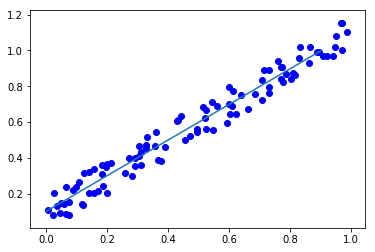

In [129]:
plot_fit(feature, target, coefficients, intercept).show()

### => regression using Normal Equation

coefficients (slope):  [0.99329287]
intercept:  0.1027199


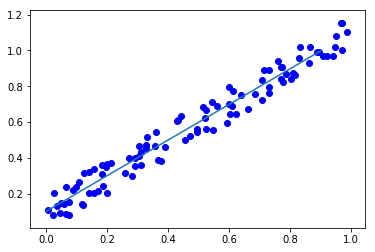

In [133]:
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)
with tf.Session() as sess:
    theta_value = theta.eval()
intercept, coefficients = theta_value
intercept = intercept[0]
print "coefficients (slope): ", coefficients
print "intercept: ", intercept
plot_fit(feature, target, coefficients, intercept).show()

### => regression using Batch Gradient Descent

In [146]:
# Gradient Descent requires scaling the feature vectors first. 
# We could do this using TF, but let's just use Scikit-Learn for now.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform([feature])
scaled_X
#scaled_X_plus_bias = np.c_[np.ones((m, 1)), scaled_X]

# pd.DataFrame(data = scaled_X, columns=['feature', 'target'])
# df.head(3)

# scaled_housing_df = pd.DataFrame(
#     data= scaled_housing_data,
#     columns = housing['feature_names'])
# scaled_housing_df.head(3)

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258,
       0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
       0.18340451, 0.30424224, 0.52475643, 0.43194502, 0.29122914,
       0.61185289, 0.13949386, 0.29214465, 0.36636184, 0.45606998,
       0.78517596, 0.19967378, 0.51423444, 0.59241457, 0.04645041,
       0.60754485, 0.17052412, 0.06505159, 0.94888554, 0.96563203,
       0.80839735, 0.30461377, 0.09767211, 0.68423303, 0.44015249,
       0.12203823, 0.49517691, 0.03438852, 0.9093204 , 0.25877998,
       0.66252228, 0.31171108, 0.52006802, 0.54671028, 0.18485446,
       0.96958463, 0.77513282, 0.93949894, 0.89482735, 0.59789998,
       0.92187424, 0.0884925 , 0.19598286, 0.04522729, 0.32533033,
       0.38867729, 0.27134903, 0.82873751, 0.35675333, 0.28093451,
       0.54269608, 0.14092422, 0.80219698, 0.07455064, 0.98688694,
       0.77224477, 0.19871568, 0.00552212, 0.81546143, 0.70685

In [141]:
# Gradient Descent requires scaling the feature vectors first. 
# We could do this using TF, but let's just use Scikit-Learn for now.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
housing = fetch_california_housing()
m, n = housing.data.shape
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]


scaled_housing_df = pd.DataFrame(
    data= scaled_housing_data,
    columns = housing['feature_names'])
scaled_housing_df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827


In [96]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

#compute the gradients manually
gradients = 2./m * tf.matmul(tf.transpose(X), error)

training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        sess.run(training_op)
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
print("Best theta:")
print(best_theta)

('Epoch', 0, 'MSE =', 8.805304)
('Epoch', 100, 'MSE =', 0.56650996)
('Epoch', 200, 'MSE =', 0.5487523)
('Epoch', 300, 'MSE =', 0.5395938)
('Epoch', 400, 'MSE =', 0.5340457)
('Epoch', 500, 'MSE =', 0.53061575)
('Epoch', 600, 'MSE =', 0.52845377)
('Epoch', 700, 'MSE =', 0.5270666)
('Epoch', 800, 'MSE =', 0.5261626)
('Epoch', 900, 'MSE =', 0.5255663)
Best theta:
[[ 2.0685523e+00]
 [ 8.5735834e-01]
 [ 1.2673114e-01]
 [-3.1273839e-01]
 [ 3.4245053e-01]
 [-1.9602410e-03]
 [-4.0592730e-02]
 [-8.1566954e-01]
 [-7.8930187e-01]]


### => regression using Batch Gradient Descent & Autodiff

In [95]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

gradients = tf.gradients(mse, [theta])[0]
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

('Epoch', 0, 'MSE =', 9.161543)
('Epoch', 100, 'MSE =', 0.7145006)
('Epoch', 200, 'MSE =', 0.566705)
('Epoch', 300, 'MSE =', 0.5555719)
('Epoch', 400, 'MSE =', 0.5488112)
('Epoch', 500, 'MSE =', 0.5436362)
('Epoch', 600, 'MSE =', 0.5396294)
('Epoch', 700, 'MSE =', 0.5365092)
('Epoch', 800, 'MSE =', 0.5340678)
('Epoch', 900, 'MSE =', 0.5321474)
Best theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


### => regression using Batch Gradient Descent & Autodiff & optimizer

In [ ]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

